imports

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_nlp

loading and inspecting the dataset

In [3]:
imdb = tfds.load(
    "imdb_reviews",
    as_supervised=True,
    data_dir="data",
    download=False                             
)

I0000 00:00:1755243001.928027   37889 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5322 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

sanity check

In [5]:
list(train_reviews.take(2))

2025-08-15 13:00:02.125768: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-15 13:00:02.130435: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-15 13:00:02.130642: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">,
 <tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. Howev

now attempting subword tokenization

hyperparameters

In [6]:
VOCAB_SIZE = 10000
MAX_LENGTH = 120
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [7]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE
)

vectorize_layer.adapt(train_reviews)

2025-08-15 13:01:59.257735: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


padding function

In [8]:
def padding_func(sequences):

  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  sequences = sequences.get_single_element()

  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), 
                                                  maxlen=MAX_LENGTH, 
                                                  truncating=TRUNC_TYPE, 
                                                  padding=PADDING_TYPE
                                                 )

  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [9]:
train_sequences = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

checking the vocabulary

In [10]:
imdb_vocab_fullword = vectorize_layer.get_vocabulary()

sample_sequence = train_sequences.take(1).get_single_element()

decoded_text = [imdb_vocab_fullword[token] for token in sample_sequence]

decoded_text = ' '.join(decoded_text)

print(decoded_text)

    this was an absolutely terrible movie dont be [UNK] in by christopher walken or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the [UNK] rebels were making their cases for [UNK] maria [UNK] [UNK] appeared phony and her [UNK] affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher [UNK] good name i could barely sit through it


now computing the subword vocabulary

In [11]:
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_reviews,
    vocabulary_size=8000,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file='imdb_vocab_subwords.txt'
)

initializing subword tokenizer

In [12]:
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='imdb_vocab_subwords.txt'
)

2025-08-15 13:04:24.993302: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:324] The empty string is found in the vocabulary, which takes place in the token id space but will never be used in the result. Consider cleaning it from the vocabulary.
2025-08-15 13:04:24.993756: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:336] The empty suffix token is found in the vocabulary, which takes place in token id space but will (almost) never be used in the result. Consider cleaning it from the vocabulary.


In [13]:
subword_tokenizer.get_vocabulary()

['[PAD]',
 '[UNK]',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 '',
 '¡',
 '¢',
 '£',
 '¤',
 '¦',
 '§',
 '¨',
 '«',
 '®',
 '°',
 '³',
 '´',
 '·',
 'º',
 '»',
 '½',
 '¾',
 '¿',
 'À',
 'Á',
 'Ã',
 'Ä',
 'Å',
 'È',
 'É',
 'Ê',
 'Õ',
 'Ø',
 'Ü',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'ì',
 'í',
 'î',
 'ï',
 'ð',
 'ñ',
 'ò',
 'ó',
 'ô',
 'ö',
 'ø',
 'ù',
 'ú',
 'û',
 'ü',
 'ý',
 'ō',
 '–',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '₤',
 '\uf0b7',
 't

In [14]:
subword_tokenizer.vocabulary_size()

7635

another sanity check

In [15]:
sample_review = train_reviews.take(1).get_single_element()

tokenized_string = subword_tokenizer.tokenize(sample_review)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = subword_tokenizer.detokenize(tokenized_string)

print('The original string: {}'.format(original_string))

Tokenized string is [ 209  175  195  674  630  178   15  680    8   85  189   77 2000  170
  192 1766 4426  203  700   42 1864 2116   15 1961  185  255  328   13
  182  173  392  535  189  231  442  390  170  740   15  597  231  255
  282  263  186 1680 6036  173  178    8   84  908 1045   15  209  178
  168  195  638 4963 1657 1422 3263  637   15  176  258 1648  312  234
  330  223  164   36 1532 5576  758  326 4207  174  234  415  231 3925
  180 4554  174   15 3651   36  363 6855 1985 2230 1828  303 1931 7070
   13  165  202 5417   14  298 2118  179 4426  175  353  182   66 1648
 1210   81 7017  170   66  178  172  175 5789  166  269  324 1606   15
   42  427  938  172  219  185  266  199  173   13 3231  204  471    8
   84  199 1766 4426    8   84  210  627   15   42  263 1575 1169  320
  171   15]
The original string: This was an absolutely terrible movie . Don ' t be lured in by Christopher Walken or Michael Ironside . Both are great actors , but this must simply be their worst ro

In [16]:
sample_string = 'Pranav Unni, Second to None'

tokenized_string = vectorize_layer(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

decoded_text = [imdb_vocab_fullword[token] for token in tokenized_string]
original_string = ' '.join(decoded_text)
print ('The original string: {}'.format(original_string))

Tokenized string is [  1   1 326   6 589]
The original string: [UNK] [UNK] second to none


In [17]:
for ts in tokenized_string:
    detok = subword_tokenizer.detokenize([ts])
    if isinstance(detok, bytes):
        detok = detok.decode('utf-8')
    print(f'{ts} ----> {detok}')

1 ----> [UNK]
1 ----> [UNK]
326 ----> re
6 ----> %
589 ----> No


building and training the model

In [18]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

In [19]:
EMBEDDING_DIM = 64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 64)        │       488,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,037 (1.87 MB)

 Trainable params: 489,037 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset_final, epochs=num_epochs, validation_data=test_dataset_final)

Epoch 1/10


I0000 00:00:1755243275.213401   38132 service.cc:152] XLA service 0x7fedd8be8260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755243275.213419   38132 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-15 13:04:35.232213: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755243275.334967   38132 cuda_dnn.cc:529] Loaded cuDNN version 91002


152/782 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.5603 - loss: 0.6895

I0000 00:00:1755243276.158636   38132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6695 - loss: 0.6179 - val_accuracy: 0.7904 - val_loss: 0.4426
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8339 - loss: 0.3811 - val_accuracy: 0.8008 - val_loss: 0.4278
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8655 - loss: 0.3228 - val_accuracy: 0.7986 - val_loss: 0.4451
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8784 - loss: 0.2925 - val_accuracy: 0.7936 - val_loss: 0.4707
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8864 - loss: 0.2726 - val_accuracy: 0.7879 - val_loss: 0.4989
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8924 - loss: 0.2579 - val_accuracy: 0.7832 - val_loss: 0.5276
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8996 - loss: 0.2459 - val_accuracy: 0.7787 - val_loss: 0.5536
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9060 - loss: 0.2356 - val_accuracy: 0.7746 - val_

visualize results

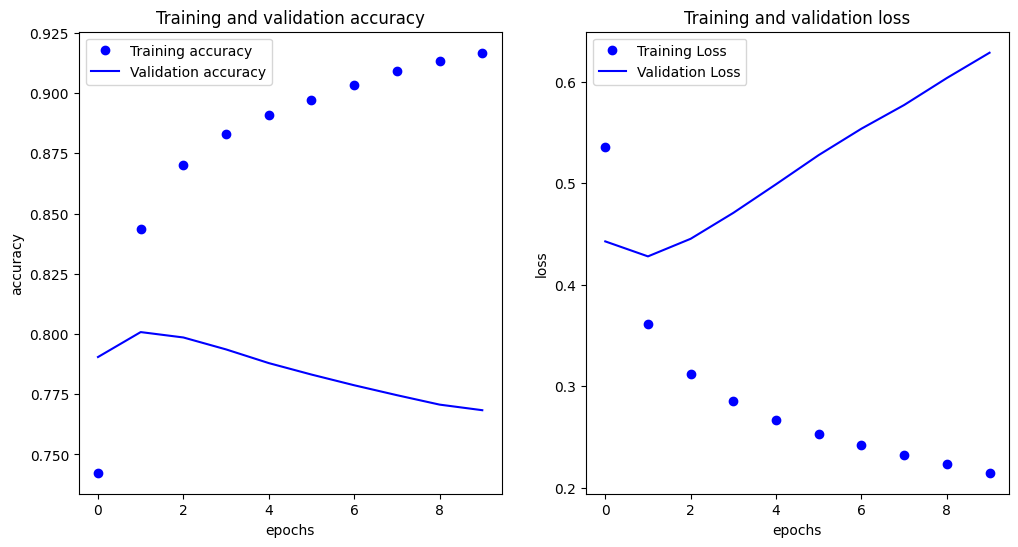

In [21]:
def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

terrible results , can't lie